# Machine Translation Project (English To Spanish)

In [1]:
import pathlib
import random
import string
import tensorflow.strings as tf_strings
import tensorflow.data as tf_data
import re
from keras.layers import TextVectorization
import keras
import tensorflow as tf
from keras import layers
import json

### Check the access of the GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2038097326522441552
xla_global_id: -1
]


### Download and Prepare the Data

source :"http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"

In [3]:
text_file =  keras.utils.get_file(
    fname = "spa-eng.zip",
    origin = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract = True,
)

text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

with open(text_file, "r") as f:
    lines = f.read().split("\n")[:-1]
    
text_pairs = []

for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

2638744/2638744 [==============================] - 4s 2us/step


In [4]:
random.shuffle(text_pairs)

In [5]:
for i in range(5):
    print(text_pairs[i])

("You're my friend.", '[start] Sos mi amiga. [end]')
('He has a habit of keeping the door open.', '[start] Tiene la costumbre de dejar la puerta abierta. [end]')
('Sit down on the bench.', '[start] Siéntate en la banca. [end]')
('Please send my regards to your family.', '[start] Por favor dales mis saludos a tu familia. [end]')
('Accidents do happen.', '[start] Los accidentes ocurren. [end]')


### Structure of the Dataset

In [6]:
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [7]:
# parameters
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

### Vectorization

In [8]:
def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

# vectorization
eng_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length,
)

spa_vectorization = TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length + 1,
    standardize = custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

#save the vectorization layers
eng_vectorization_config = eng_vectorization.get_config()
eng_vectorization_config.pop('standardize', None)
eng_vocab = eng_vectorization.get_vocabulary()
with open('eng_vectorization_config.json', 'w', encoding='utf-8') as f:
    json.dump(eng_vectorization_config, f)
    
with open('eng_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(eng_vocab, f)
    
spa_vectorization_config = spa_vectorization.get_config()
spa_vectorization_config.pop('standardize', None)
spa_vocab = spa_vectorization.get_vocabulary()
with open('spa_vectorization_config.json', 'w', encoding='utf-8') as f:
    json.dump(spa_vectorization_config, f)
    
with open('spa_vocab.json', 'w', encoding='utf-8') as f:
    json.dump(spa_vocab, f)
    

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )
    
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [9]:
for inputs,targets in train_ds.take(1):
    print(inputs["encoder_inputs"].shape)
    print(targets.shape)

(64, 20)
(64, 20)


### Model Architecture

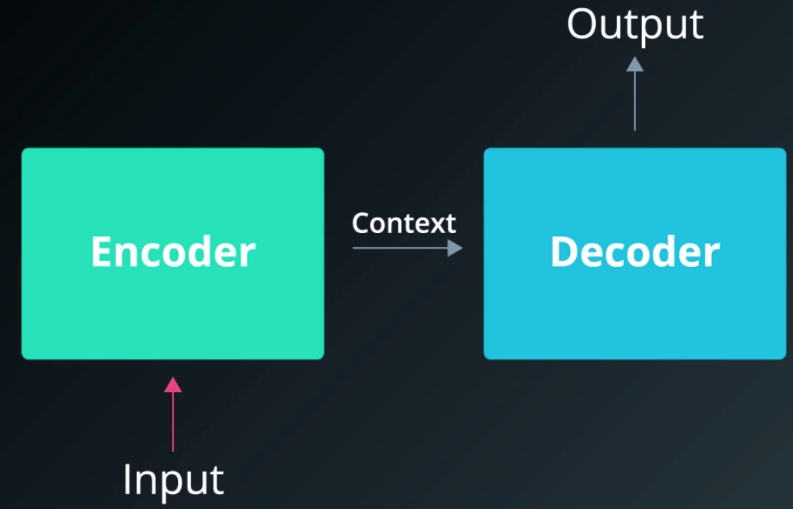

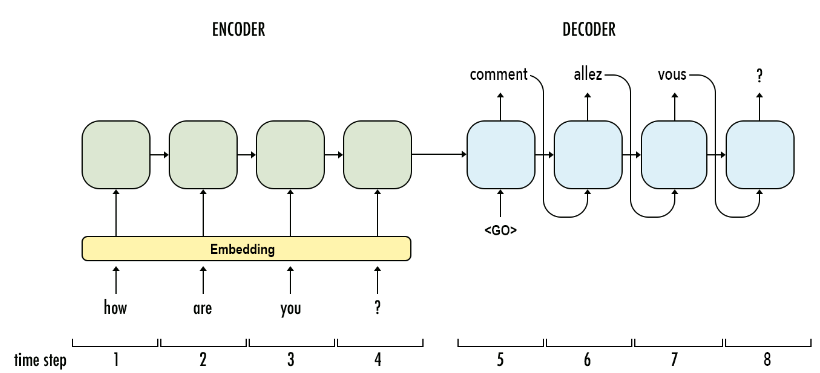

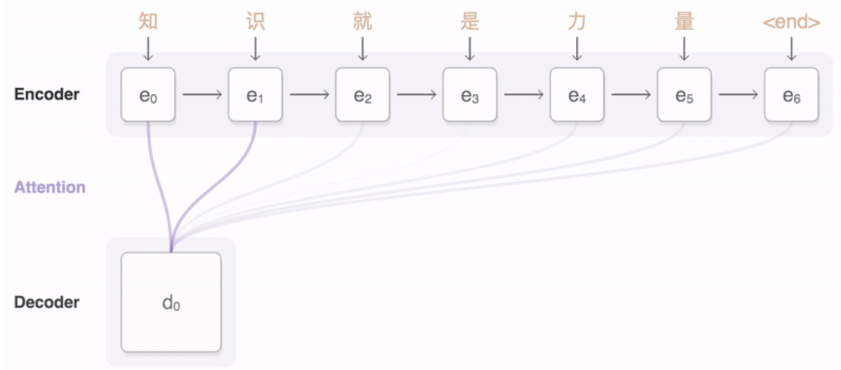

In [10]:
# Creating an Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation = "relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True
        
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype = tf.int32)
        else:
            padding_mask = None
            
        attention_output = self.attention(
            query = inputs,
            value = inputs,
            key = inputs,
            attention_mask = padding_mask,
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config
    
# Creating a Positional Embedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim = vocab_size, output_dim = embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim = sequence_length, output_dim = embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start = 0, limit = length, delta = 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None):
        if mask is not None:
            return tf.not_equal(inputs, 0)
        else:
            return None
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "sequence_length": self.sequence_length,
            "embed_dim": self.embed_dim,
        })
        return config
    
# Creating a Decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation = "relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
        
    def call(self, inputs, encoder_outputs, mask=None):
        casual_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype = tf.int32)
            padding_mask = tf.minimum(padding_mask, casual_mask)
        else:
            padding_mask = None
            
        attention_output_1 = self.attention_1(
            query = inputs,
            value = inputs,
            key = inputs,
            attention_mask = casual_mask,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query = out_1,
            value = encoder_outputs,
            key = encoder_outputs,
            attention_mask = padding_mask,
        )
        
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        proj_output = self.dense_proj(out_2)
        
        return self.layernorm_3(out_2 + proj_output)
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, None]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, tf.int32)
        mask = tf.reshape(mask,(1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.convert_to_tensor([1, 1]),
            ],
            axis = 0,
        )
        return tf.tile(mask, mult)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config

In [11]:
# define emmbedding dimensions, latent dimensions, and number of heads
embed_dim = 256
latent_dim = 2048
num_heads = 8

#Encoder
encoder_inputs = keras.Input(shape = (None,), dtype = "int64", name = "encoder_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

encoder = keras.Model(encoder_inputs, encoder_outputs, name = "encoder")

#Decoder
decoder_inputs = keras.Input(shape = (None,), dtype = "int64", name = "decoder_inputs")
encoder_seq_inputs = keras.Input(shape = (None, embed_dim), name = "encoder_seq_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoder_seq_inputs)

x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation = "softmax")(x)

decoder = keras.Model([decoder_inputs, encoder_seq_inputs], decoder_outputs, name = "decoder")

# Define the final model
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name = "transformer"
)

In [12]:
epochs = 20

transformer.summary()

transformer.compile(
    "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]
)

transformer.fit(train_ds, epochs = epochs, validation_data = val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [13]:
transformer.save("transformer_model")

INFO:tensorflow:Assets written to: transformer_model\assets


INFO:tensorflow:Assets written to: transformer_model\assets


In [14]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = sequence_length

def decode_sentence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = tf.argmax(predictions[0, i, :]).numpy().item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    input_sentence = input_sentence.lower()
    input_sentence = input_sentence.translate(str.maketrans('', '', strip_chars))
    translated = decode_sentence(input_sentence)
    print(f"input: {input_sentence}")
    print(f"translated: {translated}")
    print()

input: i dont like it at all
translated: [start] no me gusta eso [end]

input: tom spent time with mary
translated: [start] tom pasó a mary con el tiempo [end]

input: he neglected his duties
translated: [start] Él [UNK] sus [UNK] [end]

input: have you ever dug a hole as deep as this one
translated: [start] has [UNK] un [UNK] como este [UNK] [end]

input: the bear ran after me
translated: [start] el [UNK] se fue después [end]

